In [36]:
#Task 4
!pip install opendatasets
!pip install catboost
!pip install spacy
!pip install wordcloud


In [37]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import spacy
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import spacy

In [20]:
# Read data
columns= ["id","Company","Label","Text"]
df_train = pd.read_csv("C:/Users/Dell/Downloads/tasks/twitter.csv",names=columns)
df_val = pd.read_csv("C:/Users/Dell/Downloads/tasks/twitter 2.csv",names=columns)
# Concatenate data
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,Company,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
df.shape

(75682, 4)

In [22]:
# info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       75682 non-null  int64 
 1   Company  75682 non-null  object
 2   Label    75682 non-null  object
 3   Text     74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [23]:
# check null values
df.isna().sum()

id           0
Company      0
Label        0
Text       686
dtype: int64

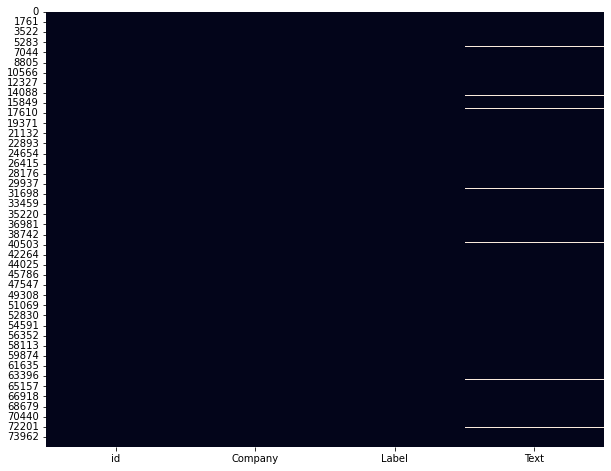

In [24]:
# Identify null data with graph
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [25]:
#EDA
# Balance in  category feature "Label"
conteo = df['Label'].value_counts()
fig = px.pie(names=conteo.index, values=conteo.values, title='Distribution of Labels')
fig.show()


In [26]:
target_count = df['Label'].value_counts().reset_index()
target_count

,index,Label
0,Negative,22808
1,Positive,21109
2,Neutral,18603
3,Irrelevant,13162


In [14]:
pd.crosstab(df.Label , df.Company).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Neutral'] , cmap='BuGn')

Label,Irrelevant,Negative,Neutral,Positive
Company,,,,
Amazon,195,582,1254,319
ApexLegends,195,606,959,652
AssassinsCreed,265,382,160,1470
Battlefield,930,481,364,597
Borderlands,242,431,612,1034
CS-GO,644,350,565,777
CallOfDuty,683,902,385,455
CallOfDutyBlackopsColdWar,584,579,366,874
Cyberpunk2077,488,391,472,983


In [15]:
# What game have more comments
conteo = df["Company"].value_counts().reset_index()
conteo.columns = ['Company', 'count']
# Create graphic of bar 
fig = px.bar(conteo, y='Company', x='count', orientation='h',
             height=1000)  # Adjust chart height
fig.show()

In [28]:
# Game with more positive comments
df1 = df.groupby(['Company', 'Label']).size().reset_index(name='count')
# Filter rows where  'Label' is 'Positive'
df1_positive = df1[df1['Label'] == 'Positive']
# Sort descending
df1_positive = df1_positive.sort_values(by='count', ascending=True)
# Show
print(df1_positive.head(4))

# Create graphic of bar with px
fig = px.bar(df1_positive, y='Company', x='count', orientation='h', title='Top Positive Comments',
             color='count')
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='bar'))
fig.update_layout(height=900)
# Show
fig.show()

             Company     Label  count
47          Facebook  Positive    177
127  johnson&johnson  Positive    274
3             Amazon  Positive    319
55            Google  Positive    363


In [29]:
# Game with more negative commnets 
df2 = df.groupby(['Company', 'Label']).size().reset_index(name='count')
# Filter rows where 'Label' is 'Negative'
df1_negative = df1[df1['Label'] == 'Negative']
# Sort descending
df1_negative = df1_negative.sort_values(by='count', ascending=True)
# Show
print(df1_negative.head(4))


# Create graphic of bar with px
fig = px.bar(df1_negative, y='Company', x='count', orientation='h', title='Top Negative Comments',
             color='count')
fig.update_traces(marker=dict(colorscale='Plasma'), selector=dict(type='bar'))
fig.update_layout(height=900)
# Show 
fig.show()

                    Company     Label  count
101  RedDeadRedemption(RDR)  Negative    311
117            WorldOfCraft  Negative    343
21                    CS-GO  Negative    350
9            AssassinsCreed  Negative    382


In [30]:
# Game with more neutral comments
df2 = df.groupby(['Company', 'Label']).size().reset_index(name='count')
# Filter rows where 'Label' is 'Neutral'
df1_neutro = df1[df1['Label'] == 'Neutral']
# Sort descending
df1_neutro = df1_neutro.sort_values(by='count', ascending=True)
# Show
print(df1_neutro.head(4))


# Create graphic of bar with px
fig = px.bar(df1_neutro, y='Company', x='count', orientation='h', title='Top Neutral Comments',
             color='count')
fig.update_traces(marker=dict(colorscale='Plasma'), selector=dict(type='bar'))
fig.update_layout(height=900)
# Show of graphic
fig.show()

           Company    Label  count
42            FIFA  Neutral    106
10  AssassinsCreed  Neutral    160
50        Fortnite  Neutral    169
74       MaddenNFL  Neutral    206


In [31]:
# Calculate the number of words per sentence
df = df.dropna(subset=['Text'])# Eliminamos las filas con  NaN.
# Apply method to count
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [32]:
# Apply hist. in "word_count"
fig = px.histogram(df, x='word_count', title='Histogram of Word Count per Sentence')
fig.show()

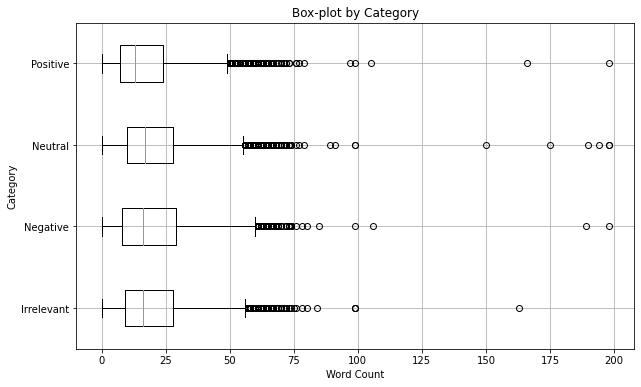

In [33]:
# Clustering for category data
grouped_data = df.groupby('Label')['word_count'].apply(list)
# Create graphic box
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_data.values, labels=grouped_data.index, vert=False)
plt.title('Box-plot by Category')
plt.xlabel('Word Count')
plt.ylabel('Category')
plt.grid(True)
plt.show()